# Sentiment Analysis with Ngrams
* **Name:** Mohammad Mahdi Salmani

In [4]:
import nltk
import numpy as np
import pandas as pd
from nltk import ngrams
from nltk.probability import FreqDist
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/dataset/data')

Mounted at /content/drive


In [6]:
# Step 1: Load the data
data = pd.read_csv('google_play_store_apps_reviews.csv')

# Step 2: Split the data
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)

In [ ]:
data.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


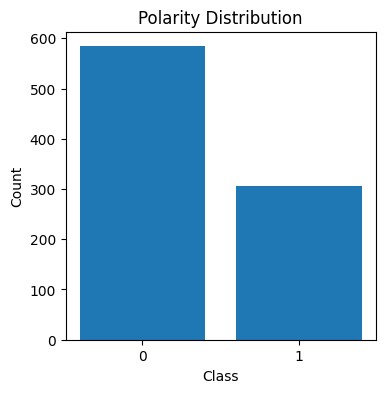

In [ ]:
import matplotlib.pyplot as plt

class_distribution = data['polarity'].value_counts()

plt.figure(figsize=(4, 4))
plt.bar(['0','1'], class_distribution)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Polarity Distribution')
plt.show()

In [7]:
# Step 3: Build the n-gram Language Model
def get_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    return list(ngrams(tokens, n))

def train_ngram(data, n):
    positive_ngrams = []
    negative_ngrams = []

    for index, row in data.iterrows():
        grams = get_ngrams(row['review'], n)
        if row['polarity'] == 1:
            positive_ngrams.extend(grams)
        elif row['polarity'] == 0:
            negative_ngrams.extend(grams)

    positive_freq = FreqDist(positive_ngrams)
    negative_freq = FreqDist(negative_ngrams)

    return positive_freq, negative_freq

# Step 4: Train the Model
n = 2  # Change to the desired n-gram size
positive_freq, negative_freq = train_ngram(train_data, n)

In [8]:
print(sum(negative_freq.values()))
print(sum(positive_freq.values()))

23318
10549


In [9]:
neg_prior = len(data[data['polarity']==0]) / len(data)
pos_prior = len(data[data['polarity']==1]) / len(data)

In [90]:
from math import log

# Step 5: Test the n-gram
def test_ngram(data, positive_freq, negative_freq, n, prior_probabilities):
    pred_labels = []
    neg_prior, pos_prior = prior_probabilities
    total_pos = sum(positive_freq.values())
    total_neg = sum(negative_freq.values())

    for index, row in data.iterrows():
        review = row['review']
        pos_log_likelihood = 0
        neg_log_likelihood = 0

        # positive score
        pos_grams = get_ngrams(review, n)
        for gram in pos_grams:
            pos_log_likelihood += log(positive_freq.get(gram, 0.001) / total_pos)

        # negative score
        neg_grams = get_ngrams(review, n)
        for gram in neg_grams:
            neg_log_likelihood += log(negative_freq.get(gram, 0.001) / total_neg)

        pos_score = pos_log_likelihood + log(pos_prior)
        neg_score = neg_log_likelihood + log(neg_prior)

        if pos_score > neg_score:
            pred_labels.append(1)  # Positive
        else:
            pred_labels.append(0)  # Negative
    return pred_labels

In [91]:
pred_labels = test_ngram(test_data, positive_freq, negative_freq, n, prior_probabilities=(neg_prior, pos_prior))

In [19]:
# Step 6: Evaluate the model on the test set
def evaluate(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print(f"Accuracy:\t% {accuracy*100:.2f}")
    print(f"Precision:\t% {precision*100:.2f}")
    print(f"Recall:\t\t% {recall*100:.2f}")
    print(f"F1 Score:\t% {f1*100:.2f}")

In [92]:
true_labels = test_data['polarity'].tolist()
evaluate(true_labels, pred_labels)

Accuracy:	% 78.77
Precision:	% 69.81
Recall:		% 62.71
F1 Score:	% 66.07


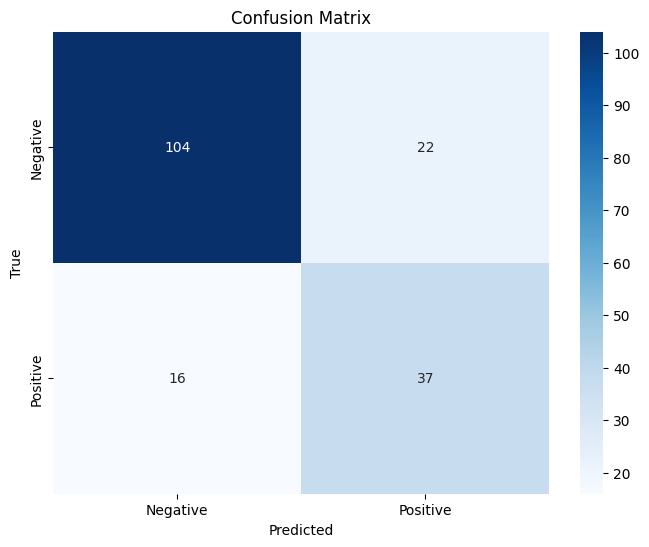

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()